<div style="text-align: center">
    <div style="font-size: xxx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">
        ObsPy - Intro
    </div>
    <div style="font-size: x-large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">
        UTCDateTime + Trace + Stream + Inventory + Catalog + Client
    </div>
</div>

ObsPy is an open-source project dedicated to provide a Python framework for processing seismological data.

It provides:
* parsers for common file formats
* clients to access data centers
* seismological signal processing routines

The goal of the ObsPy project is to facilitate rapid application development for seismology.

To facilitate this, ObsPy provides various interfaces:
* **[UTCDateTime](#UTCDateTime):** An object that simplifies working with times
* **[Trace](#Trace)**: An object that encompasses time series data (seismic signals) and metadata (station location, ...)
* **[Stream](#Stream)**: An object that encompasses multiple `Trace` objects to bundle waveform data from multiple stations into a single object.
* **[Inventory](#Inventory)**: An object that handles station metadata encompassing `Network`s which combine multiple `Station`s with individual `Channels`. This is needed for an instrument correction.
* **[Catalog](#Catalog)**: An object that combines seismic event data, e.g. an eruption of a volcano.
* **[Client](#Client)**: An object that simplifies connecting to and downloading data from data centers.

A complete list of the main classes and function can be found in the [ObsPy - Documentation](https://docs.obspy.org/packages/obspy.core.html#classes-functions)

# UTCDateTime

- Used everwhere in ObsPy
- All absolute time values are consistently handled with this class
- In Coordinated Universal Time (UTC) so no need to deal with timezones, daylight savings, ...

More details in the [ObsPy - Documentation - UTCDateTime](https://docs.obspy.org/packages/autogen/obspy.core.utcdatetime.UTCDateTime.html)

In [1]:
from obspy import UTCDateTime

## Creation

### Time strings defined by ISO standard

```
YYYY-MM-DDThh:mm:ss.sTZD
```

```
YYYY = four-digit year
MM   = two-digit month (01=January, etc.)
DD   = two-digit day of month (01 through 31)
hh   = two digits of hour (00 through 23) (am/pm NOT allowed)
mm   = two digits of minute (00 through 59)
ss   = two digits of second (00 through 59)
s    = one or more digits representing a decimal fraction of a second
TZD  = time zone designator (Z or +hh:mm or -hh:mm)
```

In [2]:
UTCDateTime("2011-03-11T05:46:23.2")

2011-03-11T05:46:23.200000Z

### Non-UTC timezone input

In [3]:
UTCDateTime("2011-03-11T14:46:23.2+09:00")

2011-03-11T05:46:23.200000Z

In [4]:
#           YYYY, M, DD, h, mm, ss, s
UTCDateTime(2011, 3, 11, 5, 46, 23, 200000)

2011-03-11T05:46:23.200000Z

### Timestamp input

The unix time stamp is a way to track time as a running total of seconds. This count starts at the Unix Epoch on January 1st, 1970 at UTC. Therefore, the unix time stamp is merely the number of seconds between a particular date and the Unix Epoch.

In [5]:
UTCDateTime(1299822383.2)

2011-03-11T05:46:23.200000Z

### Current time

In [6]:
UTCDateTime()

2020-04-13T16:10:40.961296Z

## Access

### Attributes of UTCDateTime

In [7]:
time = UTCDateTime()

year = time.year
julday = time.julday
timestamp = time.timestamp
weekday = time.weekday

print(time)
print(f"Year = {year}, Julday = {julday}, Timestamp = {timestamp}, Weekday = {weekday}")

2020-04-13T16:10:40.977294Z
Year = 2020, Julday = 104, Timestamp = 1586794240.9772937, Weekday = 0


**NOTE:** `julday`or Julian day is the continuous count of days since the beginning of the year. It is used to easily calculate elapsed days between two events.

## Computation

### Adding & Subtracting UTCDateTime

- +/- defined to add seconds to an UTCDateTime object
- "-" defined to get time difference of two UTCDateTime objects in seconds

In [8]:
now = UTCDateTime()
print("Now = ", now)

Now =  2020-04-13T16:10:40.994293Z


In [9]:
an_hour_later = now + 3600
print(f"An hour later = {an_hour_later}")

An hour later = 2020-04-13T17:10:40.994293Z


In [10]:
time_difference_in_seconds = an_hour_later - now
print("Time difference in seconds = {time_difference_in_seconds}")

Time difference in seconds = {time_difference_in_seconds}


In [11]:
seconds_until_year_2100 = UTCDateTime(2100, 1, 1) - now
print(f"Seconds until year 2100 = {seconds_until_year_2100}")

Seconds until year 2100 = 2515650559.005707


# Waveform data in General

There are a myriad of waveform data formats but in Europe and the USA two formats dominate: **MiniSEED** and **SAC**

**Note:** Raw seismometer output (e.g. recorded by a `Datacube`) has to be converted to MSEED or SAC e.g. using 
- Jackseis (https://pyrocko.org/docs/current/apps/jackseis/index.html)
- GIPPtools (https://www.gfz-potsdam.de/en/section/geophysical-deep-sounding/infrastructure/geophysical-instrument-pool-potsdam-gipp/software/gipptools/)
    
**SEED**

The Standard for the Exchange of Earthquake Data (SEED) is a data format intended primarily for the archival and exchange of seismological time series data and related metadata.

[More about SEED](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed/)

**MiniSEED (MSEED)**

MiniSEED is a stripped down version of SEED containing only waveform data. There is no station and channel metadata included.
- This is what you get from datacenters and also what they store, thus the original data
- Can store integers and single/double precision floats
- Integer data (e.g. counts from a digitizer) are heavily compressed: a factor of 3-5 depending on the data
- Can deal with gaps and overlaps
- Multiple components per file
- Contains only the really necessary parameters and some information for the data providers

[More about miniSEED](https://ds.iris.edu/ds/nodes/dmc/data/formats/miniseed/)

**SAC**

- Custom format of the `sac` code.
- Simple header and single precision floating point data.
- Only a single component per file and no concept of gaps/overlaps.
- Used a lot as `sac` is very popular and additional basic information can be stored in the header (e.g. coordinates).

**SEED Identifiers**

- Nomenclature to identify seismic receivers
- **Network code**: Identifies the network/owner of the data. Assigned by the FDSN and thus unique.
- **Station code**: The station within a network. NOT UNIQUE IN PRACTICE! Always use together with a network code!
- **Location ID**: Identifies different data streams within one station. Commonly used to logically separate multiple instruments at a single station.
- **Channel codes**: Three character code: 
    - 1) Band and approximate sampling rate
    - 2) The type of instrument
    - 3) The orientation

Full station id:  NET.STA.LOC.CHAN, e.g. IV.PRMA..HHE

# Waveform data as a `Trace`

![](lecture_17/Trace.svg)

An object that encompasses time series data (seismic signals) and metadata (station location, ...).

Each Trace object has two attributes:
- **data**: points to a NumPy ndarray of the actual time series.
- **stats**: contains all meta information in a dict-like `Stats` object. For example,
  - Station location
  - Instrument (network, station, location, channel code)
  - start and endtime
  - sampling rate

A Trace also provides methods to analyze and alter the data stored within it. We will look at those later.

In [12]:
# Ignore this for now, we will explain it later
from obspy import read
trace = read('lecture_17/RJOB_061005_072159.ehz.new')[0]

For now, let's assume with have a `Trace` called `trace`. We will later see how to obtain a `Trace`.

In [13]:
trace

.RJOB..Z | 2005-10-06T07:21:59.850000Z - 2005-10-06T07:24:59.845000Z | 200.0 Hz, 36000 samples

## `Trace.data`

The actual time series data is stored by a `Trace` object in `data` as a Numpy n-dimensional array.

In [14]:
trace.data, type(trace.data)

(array([-38,  12,  -4, ..., -14,  -3,  -9]), numpy.ndarray)

In [15]:
print(trace.data[:20])

[-38  12  -4   6  26   3  14  12 -16 -22   0 -17 -12  30   7  -6 -30 -42
  -7 -15]


Modify data:

In [16]:
print(trace.data ** 2 + 0.5)
print(trace.data.max())
print(trace.data.mean())
print(trace.data.ptp())

import numpy as np
print(np.abs(trace.data))

[ 1444.5   144.5    16.5 ...,   196.5     9.5    81.5]
11690
0.106666666667
24329
[38 12  4 ..., 14  3  9]


## `Trace.stats`

Metadata associated with the time series data.

More details in the [Obspy - Documentation - Stats](https://docs.obspy.org/packages/autogen/obspy.core.trace.Stats.html)

In [17]:
trace.stats

         network: 
         station: RJOB
        location: 
         channel: Z
       starttime: 2005-10-06T07:21:59.850000Z
         endtime: 2005-10-06T07:24:59.845000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 36000
           calib: 0.0949
         _format: GSE2
            gse2: AttribDict({'auxid': 'RJOB', 'datatype': 'CM6', 'calper': 1.0, 'instype': '', 'hang': -1.0, 'vang': -1.0, 'lat': -999.0, 'lon': -999.0, 'coordsys': '', 'elev': -0.999, 'edepth': -0.999})

In [18]:
trace.stats.station

'RJOB'

In [19]:
trace.stats.starttime

2005-10-06T07:21:59.850000Z

### Changing `Stats`

- For custom applications it is sometimes necessary to directly manipulate the metadata of a Trace.
- The metadata of the Trace will **stay consistent**, as all values are derived from the starttime, the data and the sampling rate and are **updated automatically** when a dependant attribute changes.

In [20]:
# Nothing depends on channel, so no changes
trace.stats.channel = 'N'
trace.stats

         network: 
         station: RJOB
        location: 
         channel: N
       starttime: 2005-10-06T07:21:59.850000Z
         endtime: 2005-10-06T07:24:59.845000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 36000
           calib: 0.0949
         _format: GSE2
            gse2: AttribDict({'auxid': 'RJOB', 'datatype': 'CM6', 'calper': 1.0, 'instype': '', 'hang': -1.0, 'vang': -1.0, 'lat': -999.0, 'lon': -999.0, 'coordsys': '', 'elev': -0.999, 'edepth': -0.999})

In [21]:
# This changes the delta and endtime
trace.stats.sampling_rate = 10 # Sampling rate in hertz
trace.stats

         network: 
         station: RJOB
        location: 
         channel: N
       starttime: 2005-10-06T07:21:59.850000Z
         endtime: 2005-10-06T08:21:59.750000Z
   sampling_rate: 10.0
           delta: 0.1
            npts: 36000
           calib: 0.0949
         _format: GSE2
            gse2: AttribDict({'auxid': 'RJOB', 'datatype': 'CM6', 'calper': 1.0, 'instype': '', 'hang': -1.0, 'vang': -1.0, 'lat': -999.0, 'lon': -999.0, 'coordsys': '', 'elev': -0.999, 'edepth': -0.999})

# Waveform data as a `Stream`

![](lecture_17/Stream_Trace.svg)

Streams are list-like objects which contain multiple `Trace` objects. This is useful to 
- combine seismic data from various seismometers 
- group traces for processing e.g. 3 components of one station in one `Stream` 
- apply the same processing to a large number of different waveforms

Various data formats can be imported into a `Stream`. Commonly used ones are SAC and MiniSEED.

Streams can also be exported to various formats (this allows converting data to different formats).

## Reading data from disk/online

ObsPy provides the `read` method which reads waveform files into an ObsPy `Stream` object.

The function opens either one or multiple waveform files given via file name or URL. UNIX wildcards can be used to read multiple files simultaneously.

The format of the waveform file will be automatically detected if not
given. Most common formats you will encounter are supported.

**Note**: You can also specify a `starttime` and `endtime` to automatically trim the data to a specific time frame.

In [22]:
from obspy import read

stream = read("lecture_17/waveform_PFO.mseed")
type(stream)

obspy.core.stream.Stream

## Determine the number of `Trace`s in a `Stream`

In [23]:
len(stream)

2

## Accessing `Trace`s from a `Stream`

In [24]:
trace = stream[0]
type(trace)

obspy.core.trace.Trace

## `Stream` is `iterable`

In [25]:
# convenient (and nicely readabe) looping over traces
for trace in stream:
    print(trace)

.Space.. | 2020-03-10T16:42:49.813170Z - 2020-03-10T16:44:54.688170Z | 8.0 Hz, 1000 samples
.Outer.. | 2020-03-10T16:42:49.814171Z - 2020-03-10T16:44:29.614171Z | 5.0 Hz, 500 samples


## Combining `Trace`s and/or `Stream`s

This is useful, when you have data from multiple sources that you want to combine.

In [26]:
another_stream = read('lecture_17/RJOB_061005_072159.ehz.new')
merged_stream = stream + another_stream
merged_stream

3 Trace(s) in Stream:
.Space.. | 2020-03-10T16:42:49.813170Z - 2020-03-10T16:44:54.688170Z | 8.0 Hz, 1000 samples
.Outer.. | 2020-03-10T16:42:49.814171Z - 2020-03-10T16:44:29.614171Z | 5.0 Hz, 500 samples
.RJOB..Z | 2005-10-06T07:21:59.850000Z - 2005-10-06T07:24:59.845000Z | 200.0 Hz, 36000 samples

alternative: 
- st1 += st2     # add st2 to st1
- .append() method 
- .extend() method

## Saving a `Stream` to disk

In [27]:
stream.write('lecture_17/waveform_PFO_new.mseed', format='MSEED')

# Plotting Waveform data

Here you will learn how to visualize waveform data.

**NOTE**: Many operations within ObsPy can be performed either on a single `Trace` or automatically on multiple `Trace`s when they are combined in a `Stream`.

For more options see [Obspy - Tutorial - Plotting](https://docs.obspy.org/tutorial/code_snippets/waveform_plotting_tutorial.html)

In [28]:
# Example data
from obspy import read
st = read()
st

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

## Plotting a `Stream`

Because the stream includes two traces, we will also get two waveform plots.

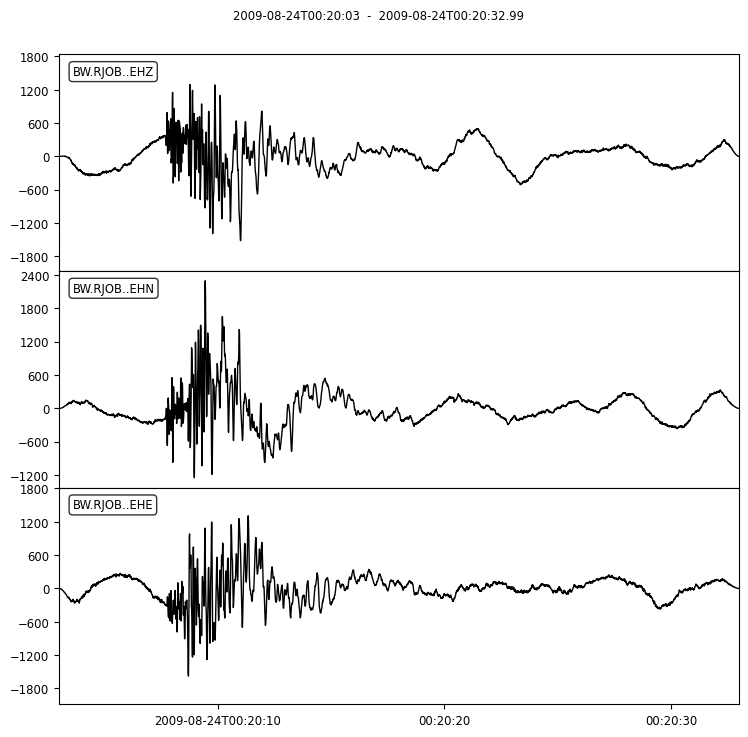

In [29]:
import matplotlib.pyplot as plt

figure = st.plot()
plt.show(figure)

## Plotting a `Trace`

We could also just plot a single trace.

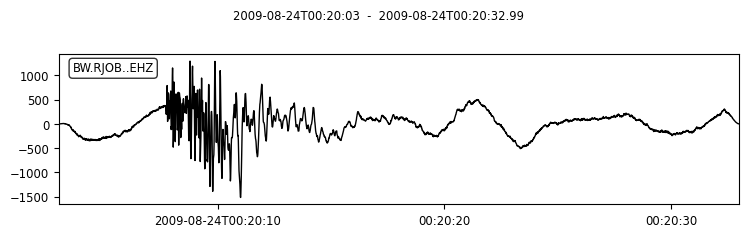

In [30]:
figure = st[0].plot()
plt.show(figure)

## Plotting a `Stream` as a spectrogram

This will create subplots if `len(stream) > 1` 

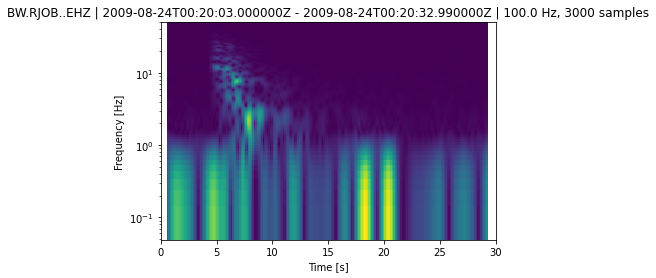

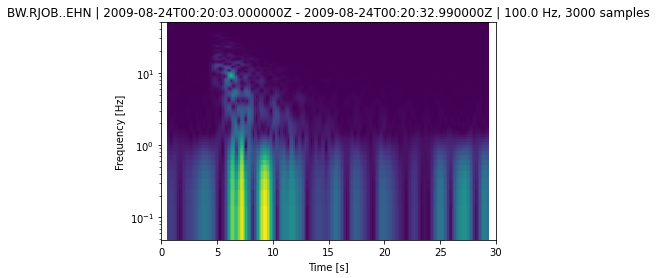

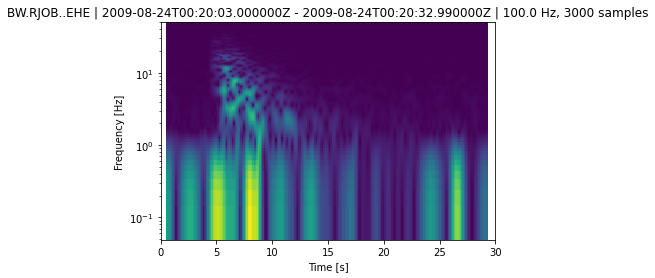

In [31]:
figure = st.spectrogram(log=True)
plt.show(figure)

## Plotting a `Trace` as a spectrogram

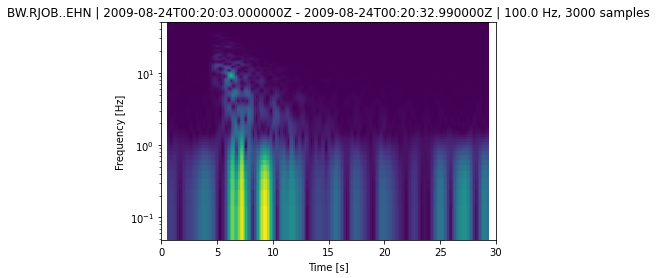

In [32]:
figure = st[1].spectrogram(log=True)
plt.show(figure)

# Inventory

![](lecture_17/Inventory.svg)

An object that handles station metadata encompassing `Network`s which combine multiple `Station`s with individual `Channels`. It is a representation of a real world setup, e.g. 5 seismometers scattered around a volcano in Hawaii.

An `Inventory` object does not store waveform data!

Station metadata contains:
- Info about organization that collects the data, geographical information, instrument response

Possible file formats: 
- **(dataless) SEED**: Very complete but pretty complex & binary. Still used a lot, e.g. for the Arclink protocol
- **RESP**: A strict subset of SEED. ASCII based. Contains ONLY the response.
- **StationXML**: Essentially like SEED but cleaner and based on XML. Most modern format and what the datacenters nowadays serve. Use this if you can. [FDSN StationXML](http://www.fdsn.org/xml/station/)

More details in the [Obspy - Documentation - Inventory](https://docs.obspy.org/packages/obspy.core.inventory.html?highlight=inventory#module-obspy.core.inventory)

**NOTE**: StationXML files need to be created for each seismological experiment and are used for the instrument correction !

## Loading a StationXML file into an Inventory

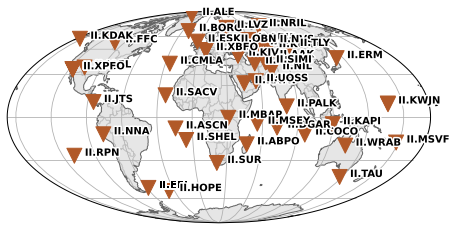

In [33]:
from obspy import read_inventory

inventory = read_inventory(
    'lecture_17/stationxml_iris_gsn_II.xml',
    format='STATIONXML'
)
fig = inventory.plot()
plt.show(fig)

In [34]:
network = inventory[0]
network

Network II (Global Seismograph Network - IRIS/IDA (GSN))
	Station Count: 57/57 (Selected/Total)
	1986-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (57):
			II.AAK (Ala Archa, Kyrgyzstan)
			II.ABKT (Alibek, Turkmenistan)
			II.ABPO (Ambohimpanompo, Madagascar)
			II.ALE (Alert, NU, Canada)
			II.ARTI (Arti, Russia)
			II.ARU (Arti, Russia) (2x)
			II.ASCN (Butt Crater, Ascension Island)
			II.BFO (Black Forest Observatory, Schiltach, Germany)
			II.BORG (Borgarfjordur, Asbjarnarstadir, Iceland)
			II.BORK (Burabay, Kazakhstan)
			II.BRVK (Borovoye, Kazakhstan)
			II.CMLA (Cha de Macela, Sao Miguel Island, Azores)
			II.COCO (West Island, Cocos (Keeling) Islands)
			II.DGAR (Diego Garcia, Chagos Islands, Indian Ocean)
			II.EFI (Mount Kent, East Falkland Island)
			II.ERM (Erimo, Hokkaido Island, Japan)
			II.ESK (Eskdalemuir, Scotland, UK)
			II.FFC (Flin Flon, Canada)
			II.GAR (Garm, Tajikistan)
			II.HOPE (Hope Point, South Georgia Island)
			II.IASL (Albuquerque 

In [35]:
station = network[0]
station

Station AAK (Ala Archa, Kyrgyzstan)
	Station Code: AAK
	Channel Count: 0/326 (Selected/Total)
	1990-10-12T00:00:00.000000Z - 
	Access: open 
	Latitude: 42.64, Longitude: 74.49, Elevation: 1633.1 m
	Available Channels:


In [36]:
# This Station has no channel attached to it
# channel = station[0]

## Saving an Inventory as StationXML

An `Inventory` can be stored as a **[StationXML](https://www.fdsn.org/xml/station/)** file.

The purpose of the FDSN StationXML schema is to define an XML representation of the most important and commonly used structures of SEED 2.4 metadata with enhancements.

In [37]:
inventory.write(
    'lecture_17/stationxml_iris_gsn_II.xml',
    format='STATIONXML'
)

# Catalog

![](lecture_17/Catalog.svg)

Obspy can read event metadata. Similar to `Stream` and `Trace`, multiple `Event`s are stored in a `Catalog`.

`Event` describes a seismic event which does not necessarily need to be a tectonic earthquake. An event is usually associated with one or more `Origins` ([see Obspy - Documentation - Origin](https://docs.obspy.org/packages/autogen/obspy.core.event.origin.Origin.html#obspy.core.event.origin.Origin)), which contain information about focal time and geographical location of the event. Multiple origins can cover automatic and manual locations, a set of location from different agencies, locations generated with different location programs and earth models, etc. Furthermore, an event is usually associated with one or more magnitudes, and with one or more focal mechanism determinations.

More details in the [ObsPy - Documentation - Catalog](https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html#obspy.core.event.Catalog)

To find events within IRIS you could also use this [IRIS Event Finder](https://ds.iris.edu/wilber3/find_event) or Client which will be next up.

6 Event(s) in Catalog:
2020-02-23T16:00:31.630000Z | +38.493,  +44.373 | 6.0 mww
2020-02-13T10:33:44.492000Z | +45.631, +148.929 | 7.0 mww
2020-02-09T06:04:29.967000Z |  -5.492, +152.152 | 6.1 mww
2020-02-08T14:32:58.625000Z | -59.921,  -25.553 | 6.0 mww
2020-02-06T13:40:09.255000Z |  +5.469, +126.494 | 6.0 Mww
2020-02-05T18:12:37.734000Z |  -6.082, +113.078 | 6.2 mww


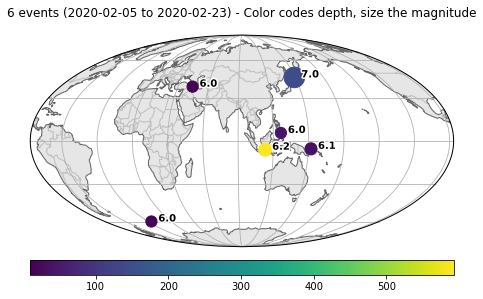

In [38]:
from obspy import UTCDateTime
from obspy import read_events

catalog = read_events(
    "lecture_17/catalog_iris_2020-02-01_to_2020-03-01.quakeml",
    format="QUAKEML"
)

print(catalog)

fig = catalog.plot()
plt.show(fig)

# Client

Working with remotely stored data and data centers.

ObsPy has clients to directly fetch data via...

- FDSN webservices (IRIS, Geofon/GFZ, USGS, NCEDC, SeisComp3 instances, ...)
- ArcLink (EIDA, ...)
- Earthworm
- SeedLink (near-realtime servers)
- NERIES/NERA/seismicportal.eu
- NEIC
- SeisHub (local seismological database)

For all custom processing workflows it does not matter if the data originates from a local file or from a web service.

## Fetch data via FDSN

- FDSN = International Federation of Digital Seismograph Networks
- The FDSN webservice definition is by now the default web service implemented by many data centers world wide.
- Download data from data centers across the globe including IRIS, ORFEUS, ETH, RESIF, GEONET, …
- Exceptions are most Asian countries / countries that don't freely share their data
- Clients for other protocols work similar to the FDSN client.

## Getting an `Inventory`

Let's get all stations for the [(GSN) Global Seismograph Network (IRIS/IDA) ](https://ds.iris.edu/mda/II/) network from a data center and visualize them.

- station information is time dependent due to changed sensors, new calibrations, or other changes
- important to specify the time frame for which to request response information

`get_stations()` returns StationXLM files

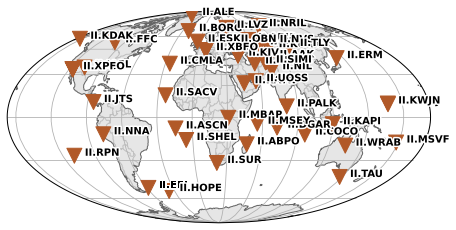

In [39]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS") # initialize Client class with data center you want to download from
inventory = client.get_stations(network='II')

fig = inventory.plot()
plt.show(fig)

## Station lookup

Stations can be looked up using a wide range of constraints
- network/station code
- time range of operation
- geographical (lonlat-box, circular by distance)

In [40]:
event = catalog[0]
origin = event.origins[0]
lon= 7.63      # Münster
lat= 51.96     # Münster
inventory = client.get_stations(longitude=lon, latitude=lat, maxradius=2.5, level="station")
print(inventory)

Inventory created at 2020-04-13T16:10:51.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?level=station&latitu...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (5):
			BE, GE, NL, SG, SY
		Stations (19):
			BE.MEM (Membach, Belgium)
			BE.RCHB (Rochefort, Belgium)
			BE.UCC (Uccle, Brussels, Belgium) (2x)
			GE.FLT1 (Temp GEOFON Station Flechtingen, Germany)
			GE.HLG (UKiel/GEOFON Station Helgoland, Germany) (2x)
			GE.IBBN (RUB/GEOFON Station Ibbenbueren, Germany)
			GE.WLF (GEOFON Station Walferdange, Luxembourg) (2x)
			NL.HGN (HEIMANSGROEVE, NETHERLANDS)
			SG.MEMB (Membach, Belgium)
			SG.RCHS (Rochefort, Belgium)
			SY.FLT1 (FLT1 synthetic)
			SY.HGN (HGN synthetic)
			SY.HLG (HLG synthetic)
			SY.IBBN (IBBN synthetic)
			SY.RCHB (RCHB synthetic)
			SY.WLF (WLF synthetic)
		Channels (0):



**level keyword**
used to specify the level of detail in requested inventory
- **network**: only return information on networks matching the criteria
- **station**: return information on all matching stations
- **channel**: return information on available channels in all stations networks matching the criteria
- **response**: include instrument response for all matching channels (large result data size!)

In [41]:
inventory = client.get_stations(network="OE", station="DAVA", level="station")
print(inventory)

inventory = client.get_stations(network="OE", station="DAVA", level="channel")
print(inventory)

Inventory created at 2020-04-13T16:10:51.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?network=OE&station=D...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OE
		Stations (1):
			OE.DAVA (Damuels, Vorarlberg, Austria)
		Channels (0):

Inventory created at 2020-04-13T16:10:52.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?network=OE&station=D...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			OE
		Stations (1):
			OE.DAVA (Damuels, Vorarlberg, Austria)
		Channels (14):
			OE.DAVA..BHZ, OE.DAVA..BHN, OE.DAVA..BHE, OE.DAVA..HHZ, 
			OE.DAVA..HHN, OE.DAVA..HHE, OE.DAVA..LCQ, OE.DAVA..LHZ, 
			OE.DAVA..LHN, OE.DAVA..LHE, OE.DAVA..UFC, OE.DAVA..VHZ, 
			OE.DAVA..VHN, OE.DAVA..VHE


## Getting a `Catalog`

Requests can have a wide range of constraints (see [ObsPy Documentation](http://docs.obspy.org/packages/autogen/obspy.fdsn.client.Client.get_events.html)):

- time range
- geographical (lonlat-box, circular by distance)
- depth range
- magnitude range, type
- contributing agency

6 Event(s) in Catalog:
2020-02-23T16:00:31.630000Z | +38.493,  +44.373 | 6.0 mww
2020-02-13T10:33:44.492000Z | +45.631, +148.929 | 7.0 mww
2020-02-09T06:04:29.967000Z |  -5.492, +152.152 | 6.1 mww
2020-02-08T14:32:58.625000Z | -59.921,  -25.553 | 6.0 mww
2020-02-06T13:40:09.255000Z |  +5.469, +126.494 | 6.0 Mww
2020-02-05T18:12:37.734000Z |  -6.082, +113.078 | 6.2 mww


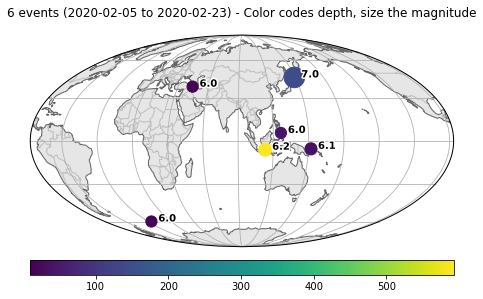

In [42]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")
catalog = client.get_events(
    starttime=UTCDateTime("2020-02-01"),
    endtime=UTCDateTime("2020-03-01"),
    minmagnitude=6.0
)

print(catalog)

fig = catalog.plot()
plt.show(fig)

## Getting a `Stream` (Waveform data)

- waveform requests that include instrument correction, the appropriate instrument response information can be attached to waveforms automatically
- For work on large datasets, the better choice is to download all station information and avoid the internal repeated webservice requests

Let's get seismic data for the [2011 Tōhoku earthquake and tsunami](https://en.wikipedia.org/wiki/2011_T%C5%8Dhoku_earthquake_and_tsunami).

In this example we get the start time from Wikipedia :)

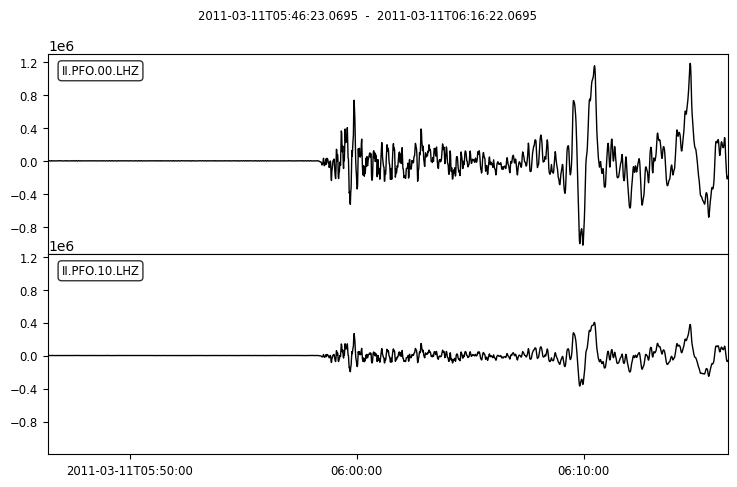

In [43]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")
time = UTCDateTime("2011-03-11T05:46:23")  # Tohoku earthquake and tsunami
stream = client.get_waveforms(
    network="II",
    station="PFO",
    location="*",
    channel="LHZ",
    starttime=time,
    endtime=time + 30 * 60 # 30 minutes
)
fig = stream.plot()
plt.show(fig)

## Saving FDSN information

- All data requested using the FDSN client can be directly saved to file using the filename="..." option. The data is then stored exactly as it is served by the data center, i.e. without first parsing by ObsPy and outputting by ObsPy.

Checkout the directory `lecture_17` to see the results for:
- [events](lecture_17/requested_events.xml)
- [stations](lecture_17/requested_stations.xml)
- [waveforms](lecture_17/requested_waveforms.mseed)

In [44]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")
t = UTCDateTime("2011-03-11T05:46:23.015400Z")

client.get_events(
    starttime=t-100, endtime=t+24*3600, minmagnitude=7,
    filename="lecture_17/requested_events.xml"
)

client.get_stations(
    network="OE", station="DAVA", level="station",
    filename="lecture_17/requested_stations.xml"
)

client.get_waveforms(
    "II", "PFO", "*", "LHZ", t + 10 * 60, t + 30 * 60,
    filename="lecture_17/requested_waveforms.mseed"
)

### Next excercise: [Exercise 17](exercise_17_obspy_intro.ipynb)
### Next lecture: [Python - Obspy - Signal Processing](lecture_18_obspy_signal_processing.ipynb)

---
##### Authors:
* [Julian Niedermeier](https://github.com/sleighsoft)
* Eva Eibl ([@evaeibl](https://github.com/evaeibl))